# Imports

First, we'll import the necessary libraries.

In [26]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import datetime
import io
import zipfile
import rasterio
from rasterio.plot import show
import sklearn
from sklearn.neighbors import KernelDensity
import numpy as np

import collections

# in response to an error importing collections, I used this: https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python

from collections.abc import Iterable

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

Next, we'll query the City of Philadelphia data via the ArcGIS REST API using the `requests` library. We'll also use the `json` library to parse the response.

Finally, we'll use the `geopandas` library to create a geodataframe from the response.

We have three different datasets to import from the City's ArcGIS server. These are:

### 1. Vacant Land

In [27]:
# Define the URL for the Vacant_Indicators_Land feature service
land_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Land/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Land API request
land_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_Land API request
land_response = requests.get(land_url, params=land_params)

# Check if the Vacant_Indicators_Land request was successful
if land_response.status_code == 200:
    # Convert the Vacant_Indicators_Land JSON data to a geopandas geodataframe; convert to CRS 3857
    land_data = land_response.json()

    # convert the JSON data to a pandas dataframe
    land_df = pd.DataFrame(land_data['features'])

    # separate the attributes column into one column per attribute
    land_df = pd.concat([land_df.drop(['attributes'], axis=1), land_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('Vacant_Indicators_Land Request failed with status code:', land_response.status_code)


# make the `geometry` column a shapely geometry object
land_df['geometry'] = land_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
land_gdf = gpd.GeoDataFrame(land_df, geometry='geometry', crs='EPSG:3857')

land_gdf.to_crs(epsg=2272, inplace=True)

### 2. Vacant Buildings

In [28]:
# Define the URL for the Vacant_Indicators_Bldg feature service
bldg_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Bldg/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Bldg API request
bldg_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_Bldg API request
bldg_response = requests.get(bldg_url, params=bldg_params)

# Check if the Vacant_Indicators_Bldg request was successful
if bldg_response.status_code == 200:
    # Convert the Vacant_Indicators_Bldg JSON data to a geopandas geodataframe; convert to CRS 3857
    bldg_data = bldg_response.json()

    # convert the JSON data to a pandas dataframe
    bldg_df = pd.DataFrame(bldg_data['features'])

    # separate the attributes column into one column per attribute
    bldg_df = pd.concat([bldg_df.drop(['attributes'], axis=1), bldg_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('Vacant_Indicators_bldg Request failed with status code:', bldg_response.status_code)


# make the `geometry` column a shapely geometry object
bldg_df['geometry'] = bldg_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
bldg_gdf = gpd.GeoDataFrame(bldg_df, geometry='geometry', crs='EPSG:3857')

bldg_gdf.to_crs(epsg=2272, inplace=True)

### Now, combine the two datasets in preparation for string cleaning.

In [29]:
columns = ['geometry', 'ADDRESS', 'BLDG_DESC',
       'OPA_ID','COUNCILDISTRICT',
       'ZIPCODE','OWNER1', 'OWNER2']

# reduce gdfs to only the columns we want
land_gdf = land_gdf[columns]

bldg_gdf = bldg_gdf[columns]

land_gdf['type'] = 'lot'

bldg_gdf['type'] = 'building'

In [30]:
# bind the two geodataframes together using pandas.concat
full_gdf = pd.concat([land_gdf, bldg_gdf], axis=0)

### Now we'll apply string cleaning to the OWNER1 and OWNER2 columns to identify public vs. private ownership.

In [31]:
public_owners = ['PHILADELPHIA LAND BANK',
                'PHILADELPHIA HOUSING AUTH',
                'CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA',
                'DEPT OF PUBLIC PROP; CITY OF PHILA',
                'DEPT PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILA',
                'PHILA REDEVELOPMENT AUTH',
                'PHILADELPHIA LAND INVESTM',
                'REDEVELOPMENT AUTHORITY O',
                'PHILADELPHIA REDEVELOPMEN',
                'PHILA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING',
                'PHILA REDEVELOPMENT AUTHO',
                'DEPT OF PUB PROP; CITY OF PHILA',
                'PHILA HOUSING DEV CORP',
                'DEP OF PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY',
                'COMMONWEALTH OF PA',
                'COMMONWEALTH OF PENNA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA',
                'PUBLIC PROP DIV; CITY OF PHILA',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                'REAL ESTATE DIV; CITY OF PHILA',
                'REAL ESTATE DIVISION; CITY OF PHILA',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING'
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMENT AUTH',
                'PHILADELPHIA HOUSING AUTHORITY',
                'PHILADELPHIA LAND BANK',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHORITY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PENNSYLVANIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PENNDOT'
]

# return unique public_owners
public_owners = list(set(public_owners))

In [32]:
# create a new column that combines the OWNER1 and OWNER2 columns according to the following rules:
# if OWNER1 is not null and OWNER2 is null, then the new column is OWNER1
# if OWNER1 is null and OWNER2 is not null, then the new column is OWNER2
# if OWNER2 starts with a preposition, then the new column is OWNER1 + OWNER2 separated by a space
# if OWNER2 does not start with a preposition, then the new column is OWNER2 + OWNER1 separated by a se


# define a function to check if a string starts with a preposition
def starts_with_preposition(string):
    prepositions = ['a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'from', 'in', 'into', 'nor', 'of', 'on', 'or', 'so', 'the', 'to', 'up', 'yet']
    if string.split(' ')[0].lower() in prepositions:
        return True
    else:
        return False
    
# define a function to combine the OWNER1 and OWNER2 columns
def combine_owners(row):
    if pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return None
    elif pd.isnull(row['OWNER1']) and not pd.isnull(row['OWNER2']):
        return row['OWNER2']
    elif not pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return row['OWNER1']
    elif starts_with_preposition(row['OWNER2']):
        return row['OWNER1'] + ' ' + row['OWNER2']
    else:
        return row['OWNER2'] + '; ' + row['OWNER1']
    
# apply the combine_owners function to the full_gdf dataframe
full_gdf['OWNER'] = full_gdf.apply(combine_owners, axis=1)

# if OWNER is 'PHILADELPHIA HOUSING AUTH' or 'PHILA HOUSING AUTHORITY', replace with 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILADELPHIA HOUSING AUTH', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING AUTHORITY', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'

# redevelopment authority typos
redev_owner_variations = ['REDEVELOPMENT AUTHORITY OF PHILA', 'PHILA REDEVELOPMENT AUTH',
'REDEVELOPMENT AUTHORITY O', 'PHILADELPHIA REDEVELOPMEN',
'PHILA REDEVELOPMENT AUTHO', 'REDEVELOPMENT AUTHORITY',
'REDEVELOPMENT AUTH']

for var in redev_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA'

# department of public property typos
dpp_owner_variations = ['DEPT OF PUBLIC PROPERTY', 'DEPT OF PUBLIC PROPERT', 'DEPT OF PUBLC PROP; CITY OF PHILA',
                        'DEPT OF PUBLIC PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROPERTY; CITY OF PHILA', 'DEPT PUB PROP; CITY OF PHILA',
                        'DEPT OF PUB PROP; CITY OF PHILA', 'DEP OF PUB PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                        'DEPT PUBLIC PROP R E DIV; CITY OF PHILA', 'PUBLIC PROP DIV; CITY OF PHILA', 'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                        'REAL ESTATE DIV; CITY OF PHILA', 'REAL ESTATE DIVISION; CITY OF PHILA']

for var in dpp_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY'

# HUD
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'

# commonwealth of pennsylvania
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PENNA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'

# phdc
full_gdf.loc[full_gdf['OWNER'] == 'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING DEV CORP', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'

# PennDOT
full_gdf.loc[full_gdf['OWNER'] == 'DEPARTMENT OF TRANSPORTAT; COMMONWEALTH OF PENNSYLVA', 'OWNER'] = 'PENNDOT'

# city of Philadelphia
full_gdf.loc[full_gdf['OWNER'] == 'CITY OF PHILADELPHIA', 'OWNER'] = 'CITY OF PHILA'

# create a new column called 'public_owner' that is True if the OWNER column is in the public_owners list
full_gdf['public_owner'] = full_gdf['OWNER'].isin(public_owners)

# drop the OWNER1 and OWNER2 columns
full_gdf = full_gdf.drop(['OWNER1', 'OWNER2'], axis=1)

In [33]:
# randomly sample ten rows from the full_gdf dataframe
full_gdf.sample(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner
88,"POLYGON ((2702790.739 249623.548, 2702814.453 ...",2520 POTTER ST,VAC LAND RES < ACRE,311028001,7,19125,building,PHILADELPHIA LAND BANK,True
702,"POLYGON ((2692859.142 276311.999, 2692850.972 ...",1652 E WASHINGTON LN,ROW B/GAR 2STY MASONRY,102273600,9,19138,building,BETTY L; CARL D DAIS,False
51,"POLYGON ((2681058.114 243784.603, 2681020.648 ...",4111 LEIDY AVE,VAC LAND RES < ACRE,062194300,3,19104,lot,WORRELL GARY,False
241,"POLYGON ((2674910.298 232293.693, 2674967.152 ...",1034 S 55TH ST,ROW B/GAR 2STY MASONRY,513134610,3,19143,building,JOHNSON-ADAMS RACHELLE,False
1714,"POLYGON ((2699591.889 248685.038, 2699589.911 ...",2310 N LAWRENCE ST,VAC LAND RES < ACRE,191266301,7,19133,lot,PHILADELPHIA HOUSING AUTHORITY,True
43,"POLYGON ((2693763.851 257543.900, 2693756.285 ...",1944 W AIRDRIE ST,ROW 2 STY MASONRY,131069700,8,19140,building,ROBINSON DELORES E,False
816,"POLYGON ((2699929.354 257859.403, 2699927.171 ...",3929 N MARSHALL ST,ROW 2 STY MASONRY,433077200,7,19140,building,EARLY NORMAN LEE,False
368,"POLYGON ((2672501.510 239288.075, 2672499.515 ...",37 N 59TH ST,ROW CONV/APT 2STY MASONRY,042107800,4,19139,building,ALSTON EMERSON D JR; ALSTON MELVIN A SR,False
113,"POLYGON ((2693229.570 269973.730, 2693219.803 ...",864 LOCUST AVE,VAC LAND RES < ACRE,122066900,8,19138,lot,ROSS ELGLINA N,False
297,"POLYGON ((2691138.088 248481.797, 2691127.787 ...",2230 DIAMOND ST,VAC LAND RES < ACRE,322266701,5,19121,lot,CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROP...,True


### 3. PHS Community Landcare Parcels

Now we can import the PHS Community LandCare parcels and spatially join them to our full_gdf, which contains all of the vacant parcels in the city (both lots and buildings).

In [34]:
# Define the URL for the Vacant_Indicators_phs_landcare feature service
phs_landcare_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_CommunityLandcare/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_phs_landcare API request
phs_landcare_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_phs_landcare API request
phs_landcare_response = requests.get(phs_landcare_url, params=phs_landcare_params)

# Check if the Vacant_Indicators_phs_landcare request was successful
if phs_landcare_response.status_code == 200:
    # Convert the Vacant_Indicators_phs_landcare JSON data to a geopandas geodataframe
    phs_landcare_data = phs_landcare_response.json()

    # convert the JSON data to a pandas dataframe
    phs_landcare_df = pd.DataFrame(phs_landcare_data['features'])

    # separate the attributes column into one column per attribute
    phs_landcare_df = pd.concat([phs_landcare_df.drop(['attributes'], axis=1), phs_landcare_df['attributes'].apply(pd.Series)], axis=1)

    # make the `geometry` column a shapely geometry object
    phs_landcare_df['geometry'] = phs_landcare_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

    # convert the pandas dataframe to a geopandas geodataframe
    phs_landcare_gdf = gpd.GeoDataFrame(phs_landcare_df, geometry='geometry', crs='EPSG:2272')

else:
    print('PHS_CommunityLandcare Request failed with status code:', phs_landcare_response.status_code)


phs_columns = ['geometry', 'ADDRESS', 'COMM_PARTN']

phs_landcare_gdf = phs_landcare_gdf[phs_columns]

In [35]:
# spatially join phs_landcare_gdf to full_gdf
joined_gdf = gpd.sjoin(full_gdf, phs_landcare_gdf, how='left', op='intersects')

# drop the index_right column and the ADDRESS_right column
joined_gdf = joined_gdf.drop(['index_right', 'ADDRESS_right'], axis=1)

# rename the ADDRESS_left column to ADDRESS
joined_gdf = joined_gdf.rename(columns={'ADDRESS_left': 'ADDRESS'})

joined_gdf['COMM_PARTN'] = joined_gdf['COMM_PARTN'].fillna('None')

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Now we need to import two more datasets from the City's Carto database (SQL).

### 1. L&I Complaints

In [36]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
complaints_sql_query = "SELECT address, service_request_id, subject, status, service_name, service_code, lat, lon FROM public_cases_fc WHERE requested_datetime >= '{}'".format(one_year_ago)

# Make the GET request
complaints_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": complaints_sql_query})

# Get the data
complaints_data = complaints_response.json()["rows"]

# convert complaints_data to a pandas dataframe
complaints_df = pd.DataFrame(complaints_data)

# Convert the data to a geopandas dataframe
complaints_gdf = gpd.GeoDataFrame(complaints_df, geometry=gpd.points_from_xy(complaints_df.lon, complaints_df.lat), crs='EPSG:2272')

# drop the lat and lon columns
complaints_gdf.drop(['lat', 'lon'], axis=1, inplace=True)

# filter for only Status = 'Open'
complaints_gdf = complaints_gdf[complaints_gdf['status'] == 'Open']

# collapse complaints_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
complaints_gdf = complaints_gdf.groupby('address')['service_name'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_complaints'
complaints_gdf.rename(columns={'service_name': 'li_complaints'}, inplace=True)


### 2. L&I Code Violations

In [37]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
violations_sql_query = "SELECT parcel_id_num, casenumber, casecreateddate, casetype, casestatus, violationnumber, violationcodetitle, violationstatus, opa_account_num, address, opa_owner, geocode_x, geocode_y FROM violations WHERE violationdate >= '{}'".format(one_year_ago)

# Make the GET request
violations_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": violations_sql_query})

# Get the data
violations_data = violations_response.json()["rows"]

# convert violations_data to a pandas dataframe
violations_df = pd.DataFrame(violations_data)

# Convert the data to a geopandas dataframe
violations_gdf = gpd.GeoDataFrame(violations_df, geometry=gpd.points_from_xy(violations_df.geocode_x, violations_df.geocode_y), crs='EPSG:2272')

# drop the lat and lon columns
violations_gdf.drop(['geocode_x', 'geocode_y'], axis=1, inplace=True)

# filter for only cases where the casestatus is 'IN VIOLATION' or 'UNDER INVESTIGATION'
violations_gdf = violations_gdf[(violations_gdf['violationstatus'] == 'OPEN')]

# collapse violations_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
violations_gdf = violations_gdf.groupby('opa_account_num')['violationcodetitle'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_violations'
violations_gdf.rename(columns={'violationcodetitle': 'li_code_violations'}, inplace=True)

In [38]:
# left join the complaints_gdf to the joined_gdf on address
joined_gdf = joined_gdf.merge(complaints_gdf, how='left', left_on='ADDRESS', right_on='address')

# left join the violations_gdf to the joined_gdf on opa_account_num
joined_gdf = joined_gdf.merge(violations_gdf, how='left', left_on='OPA_ID', right_on='opa_account_num')

# drop the address and opa_account_num columns
joined_gdf.drop(['address', 'opa_account_num'], axis=1, inplace=True)

### Import Philadelphia's Neighborhoods from Azavea

In [39]:


hoods_url = 'https://github.com/azavea/geo-data/raw/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.zip'

hoods_response = requests.get(hoods_url)

with io.BytesIO(hoods_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
hoods = gpd.read_file("path/to/destination/folder/Neighborhoods_Philadelphia.shp")

hoods = hoods.to_crs(epsg=2272)

In [40]:
# spatially join hoods to joined_gdf
joined_gdf = gpd.sjoin(joined_gdf, hoods, how='left', op='intersects')

# drop the index_right column, NAME, LISTNAME, Shape_Leng, and Shape_Area columns
joined_gdf = joined_gdf.drop(['index_right', 'NAME', 'LISTNAME', 'Shape_Leng', 'Shape_Area'], axis=1)

# change MAPNAME to neighborhood
joined_gdf.rename(columns={'MAPNAME': 'neighborhood'}, inplace=True)

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


### Import RCOs from the City

In [41]:
# Define the URL for the RCOs feature service
rcos_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Zoning_RCO/FeatureServer/0/query'

# Define the parameters for the RCOs API request
rcos_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the RCOs API request
rcos_response = requests.get(rcos_url, params=rcos_params)

# Check if the RCOs request was successful
if rcos_response.status_code == 200:
    # Convert the RCOs JSON data to a geopandas geodataframe; convert to CRS 3857
    rcos_data = rcos_response.json()

    # convert the JSON data to a pandas dataframe
    rcos_df = pd.DataFrame(rcos_data['features'])

    # separate the attributes column into one column per attribute
    rcos_df = pd.concat([rcos_df.drop(['attributes'], axis=1), rcos_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('RCOs Request failed with status code:', rcos_response.status_code)


# make the `geometry` column a shapely geometry object
rcos_df['geometry'] = rcos_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
rcos_gdf = gpd.GeoDataFrame(rcos_df, geometry='geometry', crs='EPSG:3857')

rcos_gdf.to_crs(epsg=2272, inplace=True)

rcos_cols = ['geometry', 'ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS',
       'ORG_TYPE', 'PREFFERED_CONTACT_METHOD',
       'PRIMARY_NAME', 'PRIMARY_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE',
       'EXPIRATIONYEAR']

# convert primary_phone and expirationyear to strings
rcos_gdf['PRIMARY_PHONE'] = rcos_gdf['PRIMARY_PHONE'].astype(str)
rcos_gdf['EXPIRATIONYEAR'] = rcos_gdf['EXPIRATIONYEAR'].astype(str)

In [42]:
rco_aggregate_cols = ['ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE']

rcos_gdf["rco_info"] = rcos_gdf[rco_aggregate_cols].agg("; ".join, axis=1)

In [43]:
rcos_final_cols = ['geometry', 'rco_info']

rcos_gdf = rcos_gdf[rcos_final_cols]

rcos_gdf.sample(10)

,geometry,rco_info
217,"POLYGON ((2688828.910 236756.587, 2688829.527 ...",Fitler Square Neighborhood Association; 1500 M...
168,"POLYGON ((2673615.708 244397.944, 2673608.999 ...",Hestonville Civic Association; 1623 55th Stree...
129,"POLYGON ((2675691.924 283416.459, 2675916.488 ...",Friends of the Wissahickon; 40 West Evergreen ...
58,"POLYGON ((2692379.102 223523.030, 2692310.459 ...",South Broad Street Neighborhood Association; P...
178,"POLYGON ((2680153.319 237891.765, 2680114.721 ...",Walnut Hill Community Association; The Enterpr...
32,"POLYGON ((2737770.876 301545.419, 2737956.759 ...",Somerton Civic Association; 13015 Proctor Road...
250,"POLYGON ((2670310.541 224273.574, 2670311.902 ...",Jayhawks Community Association; 5013 Upland St...
200,"POLYGON ((2691696.337 223095.451, 2691663.722 ...",Broad Street West Civic Association; 1525 W Po...
158,"POLYGON ((2745653.233 287034.452, 2745792.355 ...",Northeast Community Civic Alliance; 9605 Leon ...
74,"POLYGON ((2692628.672 218673.790, 2692550.287 ...",Friends of Historic FDR Park; 1500 Pattison Av...


### Now we can join the RCOs to the joined_gdf.

In [44]:
# spatially join rcos_gdf to joined_gdf
joined_gdf = gpd.sjoin(joined_gdf, rcos_gdf, how='right', op='within')

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [45]:
# collapse joined_gdf by opa_id and concatenate the rco_info values into a list with a | separator
rcos_by_opa_id_gdf = joined_gdf.groupby('OPA_ID')['rco_info'].apply(lambda x: '| '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'relevant_rcos'
rcos_by_opa_id_gdf.rename(columns={'rco_info': 'relevant_rcos'}, inplace=True)

# left join the rcos_by_opa_id_gdf to the joined_gdf on opa_id
joined_gdf = joined_gdf.merge(rcos_by_opa_id_gdf, how='left', left_on='OPA_ID', right_on='OPA_ID')

# drop the rco_info and index_left columns
joined_gdf = joined_gdf.drop(['rco_info', 'index_left'], axis=1)

In [46]:
joined_gdf.sample(10)

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,neighborhood,geometry,relevant_rcos
8915,2403 HARLAN ST,VAC LAND RES < ACRE,291134300,5,19121,lot,PHILADELPHIA HOUSING AUTHORITY,True,None,NaN,NaN,Sharswood,"POLYGON ((2692896.584 248277.545, 2692862.264 ...",Brewerytown Sharswood Community Civic Associat...
13978,2512 N NEWKIRK ST,ROW 2 STY MASONRY,281133200,5,19132,building,HAZEL; HARRY WITHERSPOON,False,None,NaN,UNSAFE STRUCTURE; EXTERIOR LIMIT STATE; EXTERI...,Strawberry Mansion,"POLYGON ((2690774.594 249696.582, 2690696.523 ...",North Penn Community Action Council; 2423 N 27...
4983,6031 BALTIMORE AVE,VAC LAND COMM. < ACRE,885017940,3,19143,lot,BID PROPERTIES LLC,False,None,NaN,NaN,Cobbs Creek,"POLYGON ((2674304.992 236374.379, 2674283.894 ...",Progressive Communities CDC; 413 South 60th St...
10880,1226 S BUCKNELL ST,ROW 2 STY MASONRY,361360100,2,19146,building,ALBANESE JOSEPH A,False,None,Maintenance Complaint; Dangerous Building Comp...,"UNSAFE STRUCTURE; DECKS, BALCONIES, & EXTERIOR...",Point Breeze,"POLYGON ((2692819.365 231257.205, 2692857.369 ...",Concerned Citizens of Point Breeze; Concerned ...
13757,1912 N UBER ST,VAC LAND RES < ACRE,321278301,5,19121,lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,North Central,"POLYGON ((2690774.594 249696.582, 2690696.523 ...",Temple Area Property Association (TAPA); 1639 ...
15178,6531 WOODLAND AVE,STR/OFF+APTS 3STY MASONRY,871188150,2,19142,building,BONO TINA,False,None,NaN,NaN,Paschall,"POLYGON ((2673202.592 231996.296, 2673404.754 ...",Empowered Community Development Corporation; P...
2556,4971 PENNWAY ST,ROW B/GAR 2STY MASONRY,233108700,7,19124,building,NGUYEN HUONG; NGUYEN HUONG THI LAN,False,None,NaN,NaN,Northwood,"POLYGON ((2709195.660 264634.653, 2709353.845 ...",Northwood Civic Association; P.O. Box 4890\r\n...
13526,1950 HART LN,ROW 2 STY MASONRY,252047600,7,19134,building,SUMRAIN HAMZA M; ALIMBAEV ABDUVAKHOV,False,None,Maintenance Complaint,NaN,Richmond,"POLYGON ((2702176.245 248865.210, 2702203.953 ...",Impact Community Development Corporation; 1952...
15087,6900 REGENT ST,VAC LAND IND < ACRE,885486660,2,19142,lot,SIGISMONDI JOSEPH N JR,False,None,NaN,NaN,Paschall,"POLYGON ((2669074.341 218805.690, 2669225.688 ...",Empowered Community Development Corporation; P...
9047,2424 W THOMPSON ST,ROW 3 STY MASONRY,291039910,5,19121,building,BMJ PHILLY HOLDINGS LLC,False,None,NaN,VACANT STRUCTURE & LAND; EXTERIOR AREA SANITAT...,Sharswood,"POLYGON ((2692832.774 242864.057, 2692642.686 ...",Brewerytown Sharswood Community Civic Associat...


### Finally, tree canopy data.

In [48]:
tree_url = 'https://national-tes-data-share.s3.amazonaws.com/national_tes_share/pa.zip.zip'

tree_response = requests.get(tree_url)

with io.BytesIO(tree_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
pa = gpd.read_file("path/to/destination/folder/pa.shp")

pa = pa.to_crs(epsg=2272)

phl = pa[pa['county'] == 'Philadelphia County']

tree_cols = ['tc_gap', 'geometry']

phl = phl[tree_cols]

phl.rename(columns={'tc_gap': 'tree_canopy_gap'}, inplace=True)

phl.head()

,tree_canopy_gap,geometry
5395,0.216832,"POLYGON ((2698038.313 234970.868, 2697586.173 ..."
5396,0.196093,"POLYGON ((2699640.691 237442.051, 2699638.100 ..."
5397,0.297005,"POLYGON ((2696855.043 237339.498, 2696827.290 ..."
5398,0.346134,"POLYGON ((2693798.320 238055.129, 2693725.464 ..."
5399,0.097603,"POLYGON ((2689575.081 237146.348, 2689561.703 ..."


In [49]:
# spatially join phl to joined_gdf
joined_gdf = gpd.sjoin(joined_gdf, phl, how='left', op='contains')

joined_gdf = joined_gdf.drop(['index_right'], axis=1)

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


# Gun Crimes

For our gun crime kernel density estimate, we have two steps:

### 1. Import gun crime data from the City's Carto database (SQL):

In [50]:
# Modify the SQL query
guncrime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Aggravated Assault Firearm', 'Robbery Firearm')".format(one_year_ago)

# Make the GET request
guncrime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrime_sql_query})

# Get the data
guncrime_data = guncrime_response.json()["rows"]

# convert guncrime_data to a pandas dataframe
guncrime_df = pd.DataFrame(guncrime_data)

# Convert the data to a geopandas dataframe
guncrime_gdf = gpd.GeoDataFrame(guncrime_df, geometry=gpd.points_from_xy(guncrime_df.point_x, guncrime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
guncrime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
guncrime_gdf.to_crs(epsg=2272, inplace=True)

# drop null geometry values
guncrime_gdf = guncrime_gdf[guncrime_gdf['geometry'].notnull()]

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\geopandas\geoseries.py:751: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [51]:
guncrime_gdf.head()

,text_general_code,dispatch_date,geometry
0,Robbery Firearm,2022-08-19,POINT (2726676.221 264105.934)
1,Robbery Firearm,2022-08-24,POINT (2707412.090 249356.412)
2,Robbery Firearm,2022-10-02,POINT (2702434.816 265367.796)
3,Aggravated Assault Firearm,2022-10-11,POINT (2674606.387 241816.289)
4,Robbery Firearm,2022-10-15,POINT (2699689.941 255814.088)


### 2. Create a kernel density estimate from the gun crime data:

In [58]:
# Get X and Y coordinates of well points
x_sk = guncrime_gdf["geometry"].x
y_sk = guncrime_gdf["geometry"].y

# drop null values
x_sk = x_sk.dropna()
y_sk = y_sk.dropna()

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = guncrime_gdf.total_bounds

In [59]:
# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk]).T

In [60]:
# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 5280, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Fit kernel density estimator to wells coordinates
kde_sk.fit(Xtrain_sk)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

In [61]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = "C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast.tif")

kde_path = "C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast.tif"

In [67]:
# Check if the geometries in joined_gdf are valid
valid = joined_gdf['geometry'].apply(lambda poly: poly.is_valid)

# If any of the geometries are invalid, repair them by buffering with a distance of 0
if not valid.all():
    joined_gdf['geometry'] = joined_gdf['geometry'].apply(lambda poly: poly.buffer(0) if not poly.is_valid else poly)

In [68]:
joined_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,neighborhood,geometry,relevant_rcos,tree_canopy_gap
0,1726 WOLF ST,ROW 2 STY MASONRY,262247600,2,19145,building,SCICCHITANO GINA; SCICCHITANO VICTOR,False,None,NaN,NaN,Girard Estates,"POLYGON ((2687339.066 223731.859, 2687143.929 ...",Girard Estate Neighbors Association; PO Box 20...,0.060198
0,1726 WOLF ST,ROW 2 STY MASONRY,262247600,2,19145,building,SCICCHITANO GINA; SCICCHITANO VICTOR,False,None,NaN,NaN,Girard Estates,"POLYGON ((2687339.066 223731.859, 2687143.929 ...",Girard Estate Neighbors Association; PO Box 20...,0.161624
1,422 WINONA ST,VAC LAND RES < ACRE,124060400,8,19144,lot,RICHLIN LAURA,False,None,NaN,NaN,Germantown - Westside,"POLYGON ((2693721.815 261249.011, 2693627.002 ...",SoLo/Germantown Civic Association; 4908 Wayne ...,0.013205
1,422 WINONA ST,VAC LAND RES < ACRE,124060400,8,19144,lot,RICHLIN LAURA,False,None,NaN,NaN,Germantown - Westside,"POLYGON ((2693721.815 261249.011, 2693627.002 ...",SoLo/Germantown Civic Association; 4908 Wayne ...,0.037027
1,422 WINONA ST,VAC LAND RES < ACRE,124060400,8,19144,lot,RICHLIN LAURA,False,None,NaN,NaN,Germantown - Westside,"POLYGON ((2693721.815 261249.011, 2693627.002 ...",SoLo/Germantown Civic Association; 4908 Wayne ...,0.167621


In [69]:
from rasterio.features import geometry_mask

# Define a function to extract the raster value for a given point
def extract_raster_value(point, raster, transform):
    x, y = point
    row, col = rasterio.transform.rowcol(transform, x, y)
    return raster[row, col]

# Use rasterio to open the density raster as a numpy array
with rasterio.open(kde_path) as src:
    density_raster = src.read(1)
    transform = src.transform

# Use the geometry_mask function to get a boolean mask indicating which cells in the raster contain the points
mask = geometry_mask(joined_gdf['geometry'], transform=transform, out_shape=density_raster.shape)

# Use the numpy where function to extract the values from the raster based on the mask
density_values = np.where(mask, density_raster, np.nan)

# Use the apply function to extract the raster value for each point
joined_gdf['density'] = joined_gdf.apply(lambda row: extract_raster_value(row['geometry'].coords[0], density_values, transform), axis=1)


NotImplementedError: Component rings have coordinate sequences, but the polygon does not

In [ ]:
joined_gdf.head()

<AxesSubplot: >

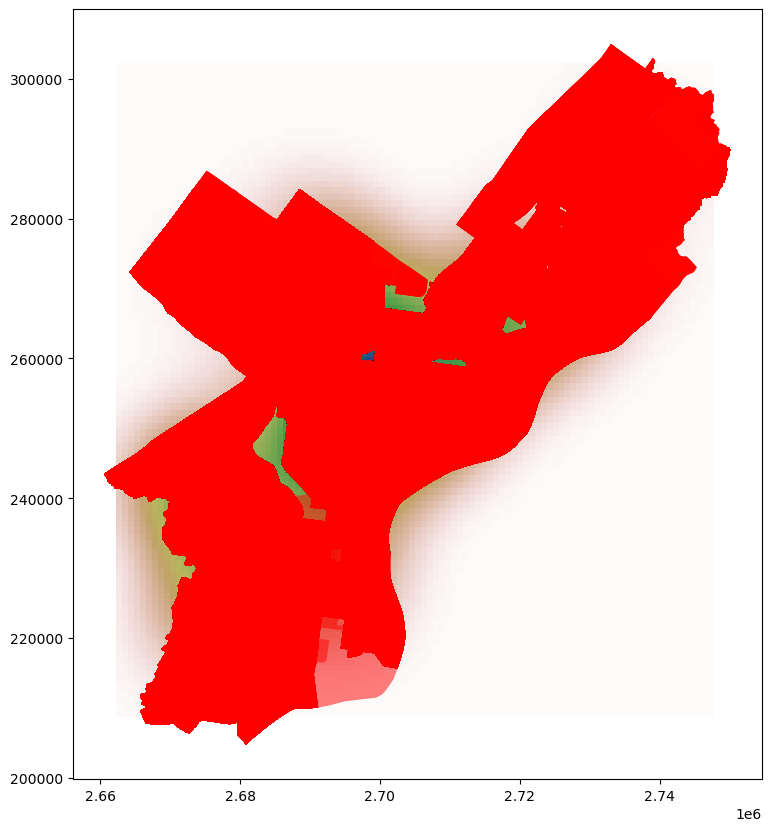

In [72]:
# plot Z_sk
plt.figure(figsize=(10,10))
plt.imshow(np.rot90(Z_sk), cmap=plt.cm.gist_earth_r, extent=[min_x_sk, max_x_sk, min_y_sk, max_y_sk])

# plot joined_gdf on top as polygons
joined_gdf.plot(ax=plt.gca(), alpha=0.5, color='red')


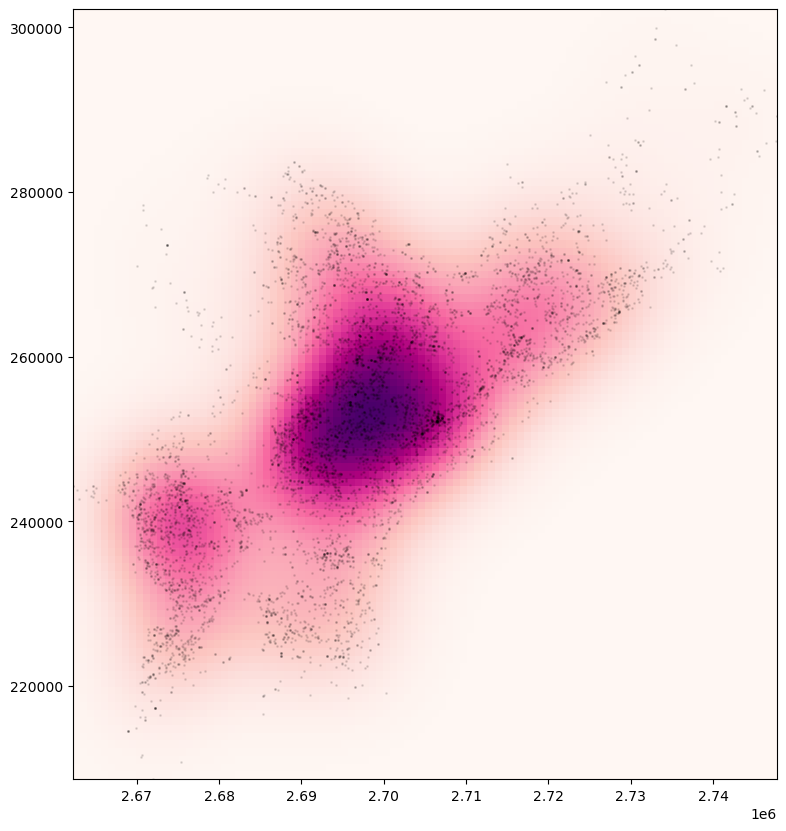

In [403]:
# Plot data
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.imshow(np.rot90(Z_sk), cmap = "RdPu", extent = [min_x_sk, max_x_sk, min_y_sk, max_y_sk])
ax.plot(x_sk, y_sk, 'k.', markersize = 2, alpha = 0.1)
plt.show()

Reclassify data into percentiles.

ImportError: cannot import name 'asscalar' from 'numpy' (c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\numpy\__init__.py)

In [388]:
from .io import read_features

def point_query(*args, **kwargs):
    """The primary point query entry point.
    All arguments are passed directly to ``gen_point_query``.
    See its docstring for details.
    The only difference is that ``point_query`` will
    return a list rather than a generator."""
    return list(gen_point_query(*args, **kwargs))


def gen_point_query(
    vectors,
    raster,
    band=1,
    layer=0,
    nodata=None,
    affine=None,
    interpolate='bilinear',
    property_name='value',
    geojson_out=False,
    boundless=True):
    """
    Given a set of vector features and a raster,
    generate raster values at each vertex of the geometry
    For features with point geometry,
    the values will be a 1D with the index refering to the feature
    For features with other geometry types,
    it effectively creates a 2D list, such that
    the first index is the feature, the second is the vertex within the geometry
    Parameters
    ----------
    vectors: path to an vector source or geo-like python objects
    raster: ndarray or path to a GDAL raster source
        If ndarray is passed, the `transform` kwarg is required.
    layer: int or string, optional
        If `vectors` is a path to a fiona source,
        specify the vector layer to use either by name or number.
        defaults to 0
    band: int, optional
        If `raster` is a GDAL source, the band number to use (counting from 1).
        defaults to 1.
    nodata: float, optional
        If `raster` is a GDAL source, this value overrides any NODATA value
        specified in the file's metadata.
        If `None`, the file's metadata's NODATA value (if any) will be used.
        defaults to `None`.
    affine: Affine instance
        required only for ndarrays, otherwise it is read from src
    interpolate: string
        'bilinear' or 'nearest' interpolation
    property_name: string
        name of property key if geojson_out
    geojson_out: boolean
        generate GeoJSON-like features (default: False)
        original feature geometry and properties will be retained
        point query values appended as additional properties.
    boundless: boolean
        Allow features that extend beyond the raster dataset’s extent, default: True
        Cells outside dataset extents are treated as nodata.
    Returns
    -------
    generator of arrays (if ``geojson_out`` is False)
    generator of geojson features (if ``geojson_out`` is True)
    """
    if interpolate not in ['nearest', 'bilinear']:
        raise ValueError("interpolate must be nearest or bilinear")

    features_iter = read_features(vectors, layer)

    with Raster(raster, nodata=nodata, affine=affine, band=band) as rast:

        for feat in features_iter:
            geom = shape(feat['geometry'])
            vals = []
            for x, y in geom_xys(geom):
                if interpolate == 'nearest':
                    r, c = rast.index(x, y)
                    window = ((int(r), int(r+1)), (int(c), int(c+1)))
                    src_array = rast.read(window=window, masked=True, boundless=boundless).array
                    val = src_array[0, 0]
                    if val is masked:
                        vals.append(None)
                    else:
                        vals.append(val.item())

                elif interpolate == 'bilinear':
                    window, unitxy = point_window_unitxy(x, y, rast.affine)
                    src_array = rast.read(window=window, masked=True, boundless=boundless).array
                    vals.append(bilinear(src_array, *unitxy))

            if len(vals) == 1:
                vals = vals[0]  # flatten single-element lists

            if geojson_out:
                if 'properties' not in feat:
                    feat['properties'] = {}
                feat['properties'][property_name] = vals
                yield feat
            else:
                yield vals

ImportError: attempted relative import with no known parent package

In [372]:
import mapclassify

In [383]:
rast_path = "C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast.tif"

# Open the TIFF file
with rasterio.open(rast_path) as src:
    # Read the data from the file into a NumPy array
    guncrime_rast = src.read(1)
    # Read the metadata for the image
    guncrime_profile = src.profile

In [386]:
joined_gdf['rast_val'] = point_query(joined_gdf, guncrime_rast)

# Define the number of classes
n_classes = 10

# Create a quantiles classifier
classifier = mapclassify.Quantiles.make(k = n_classes)

# Classify the data
joined_gdf['rast_val'] = joined_gdf[['rast_val']].apply(classifier)

# scale from 1-5 instead of 0-4
joined_gdf['rast_val'] = joined_gdf['rast_val'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['90th Percentile', '80th Percentile', '70th Percentile', '60th Percentile', '50th Percentile', '40th Percentile', '30th Percentile', '20th Percentile', '10th Percentile', '0th Percentile'])

NameError: name 'read_features' is not defined